In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.ndimage import gaussian_filter1d
import json
from scipy.special import expit
from scipy import signal

### What we want:
 - function that takes a path to folder of files and returns a folder of processed data
 - think about the parameter space
     - STIM_type
     - SIZE_dot	
     - DIST_dot	
     - AMPL_rot	
     - SPEED_rot	
     - LUM_dot
     - BGLUM

In [187]:
data = pd.read_csv('../raw_data/STIM_2_3_4_AMPLROT_/zfdata0.csv')
data

,X,Y,ANGLE,CUM_angle,TAIL_P1,TAIL_P2,TAIL_P3,TAIL_P4,TAIL_P5,TAIL_P6,...,L_EYE,R_EYE,Timestamp,STIM_type,SIZE_dot,DIST_dot,AMPL_rot,SPEED_rot,LUM_dot,BGLUM
0,387.6790,472.4093,2.424024,2.424024,0,-0.091344,-0.010366,-0.050900,-0.010366,-0.050899,...,-0.419329,0.270088,211,0,0.004,0.10,0.523599,0.35,1,0
1,387.7167,472.4317,2.423819,2.423819,0,-0.072732,-0.005218,-0.032242,-0.032243,-0.005218,...,-0.411771,0.283302,219,0,0.004,0.10,0.523599,0.35,1,0
2,387.8333,472.5522,2.424183,2.424183,0,-0.090302,0.004184,-0.063355,-0.009324,-0.049857,...,-0.423434,0.279269,222,0,0.004,0.10,0.523599,0.35,1,0
3,387.5528,472.3193,2.424412,2.424412,0,-0.090862,-0.009884,-0.050418,-0.009884,-0.063915,...,-0.424705,0.280282,227,0,0.004,0.10,0.523599,0.35,1,0
4,387.3466,472.1221,2.424077,2.424077,0,-0.073113,-0.005600,-0.046132,-0.005599,-0.032625,...,-0.422727,0.280920,233,0,0.004,0.10,0.523599,0.35,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24753,291.1328,550.2089,5.805016,5.805016,0,-0.149092,-0.014187,0.079380,0.039502,0.012716,...,-0.554447,0.502643,642,4,0.004,0.05,1.047198,0.35,1,0
24754,290.8331,550.1401,5.814559,5.814559,0,-0.137943,-0.030642,0.077282,0.063844,-0.017134,...,-0.560266,0.507282,662,4,0.004,0.05,1.047198,0.35,1,0
24755,290.6450,550.0624,5.814167,5.814167,0,-0.141079,-0.034030,0.073954,0.060491,0.020002,...,-0.550457,0.498955,681,4,0.004,0.05,1.047198,0.35,1,0
24756,290.8790,550.2361,5.812946,5.812945,0,-0.119228,-0.011713,0.069265,0.042318,-0.011713,...,-0.563759,0.502735,700,4,0.004,0.05,1.047198,0.35,1,0


In [375]:
def divide_and_preprocess_2_params(data, needed_params, final_dict):
    for p0 in data[needed_params[0]].unique():
        for p1 in data[needed_params[1]].unique():
            df = data[(data[needed_params[0]] == p0)
                        & (data[needed_params[1]] == p1)].reset_index().drop(
                            columns=['index'])
            df.Counter = df.Counter.map(
                dict(
                    zip(df.Counter.unique(),
                        np.arange(0, len(df.Counter.unique()), 1))))

            for n in df.Counter.unique():
                df_df = df[df['Counter'] == n]

                ### FIRST sort our cumulative artifacts
                new = pd.DataFrame(df_df).set_index('Timestamp').reset_index()
                for i, row in new.iterrows():
                    if i + 1 == len(new):
                        break

                    elif np.abs(new.at[i + 1, 'CUM_angle'] - new.at[i, 'CUM_angle']) >= np.pi/2:
                        #new.at[i + 1,'CUM_angle'] = new.at[i, 'CUM_angle']
                        subtract = new.at[i + 1,'CUM_angle'] - new.at[i, 'CUM_angle']
                        new.loc[i + 1:, 'CUM_angle'] -= subtract

            ### Save AMPL_rot value for calculation of relative angle of stimulus to fish head later on
                if p0 == 0:
                    stim_angle_column = np.zeros(200)
                elif p0 in [2, 3, 4, 5, 6]:
                    stim_angle_column = new['AMPL_rot'].head(200)

            ### Get rid of stimulus columns
                new = new.drop(columns=['STIM_type','SIZE_dot','DIST_dot','AMPL_rot','SPEED_rot','LUM_dot','BGLUM'])
                ### Resampling 4 second stimulus into 100 frames per second (10ms) and Interpolating
                tstp = np.arange(0, 4, 4 / len(new))  ### 4 second stimulus
                if len(new['Timestamp']) != len(tstp):
                    tstp = tstp[:-1]
                tstpdate = pd.to_datetime(tstp, unit='s')
                new['Timestamp'] = tstp
                new['tstpdate'] = tstpdate
                new = new.set_index('tstpdate')
                new_df = new.resample('20ms')
                new_df = new_df.first()
                new_df.interpolate(method='linear', inplace=True)

                interp = new_df.copy()

                ### Calculate Distance
                ### distance = sqrt((x2-x1)**2 + (y2-y1)**2) new.at[row-1,'X']
                interp['Distance_pts'] = [np.sqrt((interp['X'][row]-interp['X'][row-1])**2 + \
                                        (interp['Y'][row]-interp['Y'][row-1])**2) \
                                        for row in range(0, len(interp), 1)]

                ### Clean timestamps
                interp.insert(0, 'New_timestamp', range(1, 1 + len(interp)))
                interp = interp.drop(columns=['Timestamp']).rename(
                    columns={'New_timestamp': 'Timestamp'})
                interp['Timestamp'] = interp['Timestamp'] / 50

                ### Resetting index to integers, dropping tstp column and deleting last row of NaN
                interp = interp.reset_index()
                interp = interp.drop(columns=['tstpdate', 'level_0'])

                columns_to_smooth = ['X','Y','ANGLE','CUM_angle','TAIL_P2','TAIL_P3','TAIL_P4','TAIL_P5',\
                                     'TAIL_P6','MCURVE_tail','L_EYE','R_EYE']
                for column in columns_to_smooth:
                    interp[column] = gaussian_filter1d(interp[column], 0.25)
                interp.at[0, 'Distance_pts'] = 0
                interp['Distance_pts'] = gaussian_filter1d(
                    interp['Distance_pts'], 1)
                interp.at[0, 'Distance_pts'] = 0
                ### Set first cumulative angle to zero and adjust others
                interp['CUM_angle'] -= interp['CUM_angle'][0]
                
                ### Checking if len(interp) == 200
                if len(interp) != 200:
                    continue
                    
                ### Calculate Relative Angle of Stimulus in relation to fish
                if p0 == 0:
                    interp['Relative_stim_angle'] = stim_angle_column
                elif p0 in [2, 3, 4]:
                    interp['Relative_stim_angle'] = stim_angle_column
                elif p0 in [5, 6]:
                    interp['Relative_stim_angle'] = [ampl_rot/200*index for index,ampl_rot in \
                                                         enumerate(stim_angle_column)]

    #                 json_interp = interp.to_json()

                final_dict[f'{needed_params[0]}_{p0}'][
                    f'{needed_params[1]}_{p1}'].append(interp)
                
    return final_dict

In [376]:
data = pd.read_csv('../raw_data/STIM_5_6_SIZEDOT_0.004_0.025/zfdata20.csv')
needed_params = [param for param in parameter_space if len(data[param].unique())>1]

if len(needed_params) == 3:
    final_dict = {f'{needed_params[0]}_{param0}':{f'{needed_params[1]}_{param1}':{f'{needed_params[2]}_{param2}':[] \
                    for param2 in data[needed_params[2]].unique()} 
                    for param1 in data[needed_params[1]].unique()} 
                    for param0 in data[needed_params[0]].unique()}
elif len(needed_params) == 2:
    final_dict = {f'{needed_params[0]}_{param0}':{f'{needed_params[1]}_{param1}':[] for param1 in \
                    data[needed_params[1]].unique()} for param0 in data[needed_params[0]].unique()}
else:
    final_dict = {f'{needed_params[0]}_{param0}':[] for param0 in data[needed_params[0]].unique()}
    
### Counter to separate repeating stimuli    
data.reset_index(inplace=True)
data.Counter = 0
counter = 0
first_index = 0
for i, r in data[:-1].iterrows():
    if data.iloc[i+1].STIM_type != r.STIM_type:
        counter += 1
        data.loc[first_index:i,'Counter'] = counter
        first_index = i+1


final_dict = divide_and_preprocess_2_params(data, needed_params, final_dict)

In [377]:
len(final_dict['STIM_type_0'])

3

In [378]:
stim_0 = final_dict['STIM_type_0']

In [379]:
len(stim_0['SIZE_dot_0.0'])

59

In [283]:
data = pd.read_csv('../raw_data/STIM_5_6_SIZEDOT_0.004_0.025/zfdata26.csv')
parameter_space = ['STIM_type','SIZE_dot','DIST_dot','AMPL_rot','SPEED_rot','LUM_dot','BGLUM']
needed_params = [param for param in parameter_space if len(data[param].unique())>1]

if len(needed_params) == 3:
    final_dict = {f'{needed_params[0]}_{param0}':{f'{needed_params[1]}_{param1}':{f'{needed_params[2]}_{param2}':[] \
                    for param2 in data[needed_params[2]].unique()} 
                    for param1 in data[needed_params[1]].unique()} 
                    for param0 in data[needed_params[0]].unique()}
elif len(needed_params) == 2:
    final_dict = {f'{needed_params[0]}_{param0}':{f'{needed_params[1]}_{param1}':[] for param1 in \
                    data[needed_params[1]].unique()} for param0 in data[needed_params[0]].unique()}
else:
    final_dict = {f'{needed_params[0]}_{param0}':[] for param0 in data[needed_params[0]].unique()}

### Counter to separate repeating stimuli    
data.reset_index(inplace=True)
data.Counter = 0
counter = 0
first_index = 0
for i, r in data[:-1].iterrows():
    if data.iloc[i+1].STIM_type != r.STIM_type:
        counter += 1
        data.loc[first_index:i,'Counter'] = counter
        first_index = i+1


        
for p0 in data[needed_params[0]].unique():
    for p1 in data[needed_params[1]].unique():
        df = data[(data[needed_params[0]] == p0)
                    & (data[needed_params[1]] == p1)].reset_index().drop(
                        columns=['index'])
        df.Counter = df.Counter.map(
            dict(
                zip(df.Counter.unique(),
                    np.arange(0, len(df.Counter.unique()), 1))))

        for n in df.Counter.unique():
            df_df = df[df['Counter'] == n]

            ### FIRST sort our cumulative artifacts
            new = pd.DataFrame(df_df).set_index('Timestamp').reset_index()
            for i, row in new.iterrows():
                if i + 1 == len(new):
                    break

                elif np.abs(new.at[i + 1, 'CUM_angle'] - new.at[i, 'CUM_angle']) >= np.pi/2:
                    #new.at[i + 1,'CUM_angle'] = new.at[i, 'CUM_angle']
                    subtract = new.at[i+1, 'CUM_angle'] - new.at[i, 'CUM_angle']
                    new.loc[i+1:, 'CUM_angle'] -= subtract

            ### Save AMPL_rot value for calculation of relative angle of stimulus to fish head later on 
            if p0 == 0:
                stim_angle_column = np.zeros(200)
            elif p0 in [2,3,4,5,6]:
                stim_angle_column = new['AMPL_rot'].head(200)

        ### Get rid of stimulus columns
            new = new.drop(columns=['STIM_type','SIZE_dot','DIST_dot','AMPL_rot','SPEED_rot','LUM_dot','BGLUM'])


            ### Interpolation
            ### Resampling 4 second stimulus into 100 frames per second (10ms) and Interpolating
            tstp = np.arange(0, 4, 4 / len(new))  ### 4 second stimulus
            if len(new['Timestamp']) != len(tstp):
                tstp = tstp[:-1]
            tstpdate = pd.to_datetime(tstp, unit='s')
            new['Timestamp'] = tstp
            new['tstpdate'] = tstpdate
            new = new.set_index('tstpdate')
            new_df = new.resample('20ms')
            new_df = new_df.first()
            new_df.interpolate(method='linear', inplace=True)

            interp = new_df.copy()

            ### Calculate Distance
            ### distance = sqrt((x2-x1)**2 + (y2-y1)**2) new.at[row-1,'X']
            interp['Distance_pts'] = [np.sqrt((interp['X'][row]-interp['X'][row-1])**2 + \
                                    (interp['Y'][row]-interp['Y'][row-1])**2) \
                                    for row in range(0, len(interp), 1)]

            ### Clean timestamps
            interp.insert(0, 'New_timestamp',range(1, 1 + len(interp)))
            interp = interp.drop(columns=['Timestamp']).rename(columns={'New_timestamp': 'Timestamp'})
            interp['Timestamp'] = interp['Timestamp'] / 50

            ### Resetting index to integers, dropping tstp column and deleting last row of NaN
            interp = interp.reset_index()
            interp = interp.drop(columns=['tstpdate', 'level_0'])
#                 interp = interp[:-1]

            columns_to_smooth = ['X','Y','ANGLE','CUM_angle','TAIL_P2','TAIL_P3','TAIL_P4','TAIL_P5',\
                                 'TAIL_P6','MCURVE_tail','L_EYE','R_EYE']
            for column in columns_to_smooth:
                interp[column] = gaussian_filter1d(interp[column],0.25)
            interp.at[0, 'Distance_pts'] = 0 
            interp['Distance_pts'] = gaussian_filter1d(interp['Distance_pts'],1)
            interp.at[0, 'Distance_pts'] = 0

            ### Set first cumulative angle to zero and adjust others
            interp['CUM_angle'] -= interp['CUM_angle'][0]

            ### Calculate Relative Angle of Stimulus in relation to fish 
            if p0 == 0:
                interp['Relative_stim_angle'] = stim_angle_column
            elif p0 in [2,3,4]:
                interp['Relative_stim_angle'] = stim_angle_column 
            elif p0 in [5,6]:
                interp['Relative_stim_angle'] = [ampl_rot/200*index for index,ampl_rot in \
                                                 enumerate(stim_angle_column)]


            final_dict[f'{needed_params[0]}_{p0}'][
                f'{needed_params[1]}_{p1}'].append(interp)

0
0.0
0.004
0.025
5
0.0
0.004
0.025
6
0.0
0.004
0.025


In [564]:
# Opening JSON file
f = open('../json_data/STIM_5_6_SIZEDOT_0.004_0.025.json')
  
# returns JSON object as a dictionary
data = json.load(f)
df = pd.json_normalize(data)


final_list_of_fish_dicts = []
for i, r in df.iterrows():
    fish_dict = {}
    for stim_type in df.columns:
        fish_dict[stim_type] = []
        for counter in range(len(df[stim_type][0])-1):
            dfdf = df[stim_type][i][counter]
            dfdfdf = json.loads(dfdf)
            norm_df = pd.json_normalize(dfdfdf, max_level=0)
            empty_np = np.zeros((200,))
            for col in norm_df.columns:
                col_array = np.array([pd.json_normalize(norm_df[col])][0])[0]
                if col_array.shape == (199,):
                    col_array = np.insert(col_array,0,0)
                empty_np = np.vstack((empty_np,col_array))
            final_df = pd.DataFrame(empty_np)
            final_df = final_df.transpose().drop(columns=[0])
            final_df.columns = norm_df.columns
            fish_dict[stim_type].append(final_df)
    final_list_of_fish_dicts.append(fish_dict)
len(final_list_of_fish_dicts)

41

In [18]:
final_list_of_fish_dicts[0]

{'STIM_type_0.SIZE_dot_0.0': [     Timestamp           X           Y     ANGLE     CUM_angle  TAIL_P1  \
  0         0.02  587.731005  531.707018  0.007373 -4.593000e-07      0.0   
  1         0.04  588.639249  531.762089  0.006001 -1.369695e-03      0.0   
  2         0.06  588.203157  531.782900  0.005538 -1.830037e-03      0.0   
  3         0.08  588.234314  531.805099  0.004967 -2.399967e-03      0.0   
  4         0.10  588.009447  531.824504  0.004500 -2.870117e-03      0.0   
  ..         ...         ...         ...       ...           ...      ...   
  195       3.92  588.443832  533.238094  6.251807 -3.874975e-02      0.0   
  196       3.94  588.672070  533.238096  6.251987 -3.857000e-02      0.0   
  197       3.96  588.512923  533.226706  6.252150 -3.840006e-02      0.0   
  198       3.98  588.719798  533.233597  6.252138 -3.842001e-02      0.0   
  199       4.00  588.624032  533.232600  6.252088 -3.846998e-02      0.0   
  
        TAIL_P2   TAIL_P3   TAIL_P4   TAIL_P5

In [387]:
test_frame

,Timestamp,X,Y,ANGLE,CUM_angle,TAIL_P1,TAIL_P2,TAIL_P3,TAIL_P4,TAIL_P5,TAIL_P6,MCURVE_tail,L_EYE,R_EYE,Counter,Distance_pts
0,0.02,573.704949,502.726307,3.421640,-1.676000e-07,0.0,-0.095994,-0.001509,0.025471,0.011989,-0.001509,-0.028247,-0.334920,0.203163,8.0,0.000000
1,0.04,573.552499,502.748178,3.421100,-4.998659e-04,0.0,-0.096869,-0.002380,0.024597,0.011114,-0.002384,-0.011694,-0.349195,0.210724,8.0,0.100358
2,0.06,573.694942,502.704221,3.421022,-5.998659e-04,0.0,-0.091793,0.016185,0.029673,0.016191,0.002692,-0.005411,-0.343148,0.207329,8.0,0.107110
3,0.08,573.665503,502.723501,3.421291,-2.999665e-04,0.0,-0.091351,0.016629,0.030111,0.016629,0.003130,-0.008890,-0.333912,0.216923,8.0,0.066882
4,0.10,573.643909,502.745793,3.421689,9.989940e-05,0.0,-0.073729,0.020800,0.034270,0.020800,0.007298,0.002392,-0.329942,0.217835,8.0,0.038151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.92,543.014299,500.771833,3.033561,-3.881000e-01,0.0,-0.084943,-0.017419,-0.017414,-0.044441,-0.044458,-0.038088,-0.176938,0.282053,8.0,0.853370
196,3.94,542.806677,500.687535,3.029159,-3.924977e-01,0.0,-0.096494,-0.015529,-0.015520,-0.015530,-0.069542,-0.032600,-0.179916,0.278307,8.0,0.529908
197,3.96,543.126106,500.706489,3.031589,-3.900013e-01,0.0,-0.096376,-0.042405,-0.015398,-0.015407,-0.069425,-0.057450,-0.204524,0.276203,8.0,0.339629
198,3.98,543.462244,500.692797,3.030288,-3.912999e-01,0.0,-0.095863,-0.014907,-0.014913,-0.041919,-0.055441,-0.037860,-0.199123,0.302719,8.0,0.281098


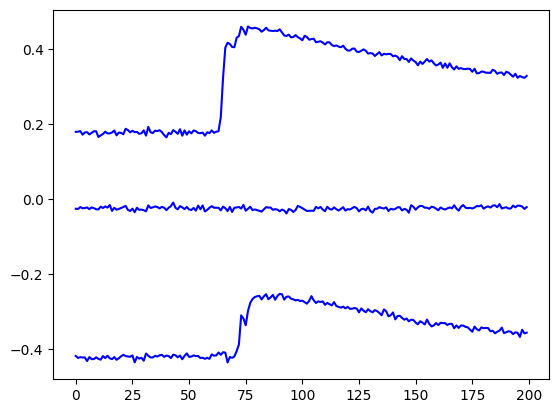

In [565]:
plt.plot(test_frame['MCURVE_tail'],label='MCURVE_tail',color='b')
plt.plot(test_frame['R_EYE'],label='MCURVE_tail',color='b')
plt.plot(test_frame['L_EYE'],label='MCURVE_tail',color='b')
# plt.plot(np.gradient(test_frame['MCURVE_tail']),color='cyan')

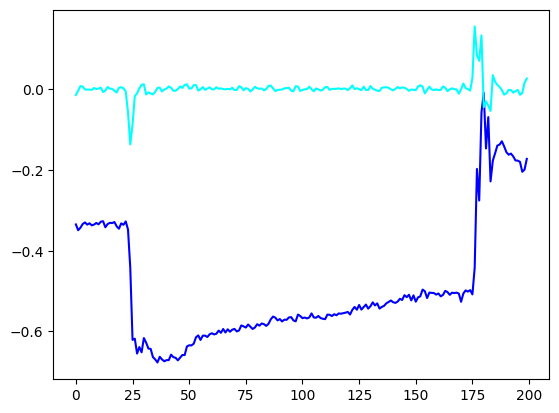

In [406]:
# plt.plot(test_frame['R_EYE'],label='Right eye',color='r')
plt.plot(test_frame['L_EYE'],label='Left eye',color='b')
# plt.plot(np.gradient(test_frame['R_EYE']),color='magenta')
plt.plot(np.gradient(test_frame['L_EYE']),color='cyan')

In [595]:
# plt.plot(test_frame['L_EYE'],label='Left eye',color='b')
# # step = np.heaviside(np.arange(0,200,200),)
# convolved = np.convolve(test_frame['L_EYE'],kaiser_bessel_derived(4,50))
# # plt.plot(convolved,label='convolved',color='cyan')

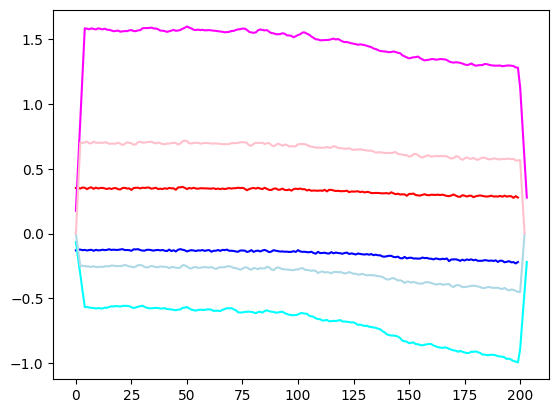

In [483]:
plt.plot(test_frame['L_EYE'],label='Left eye',color='b')
plt.plot(test_frame['R_EYE'],label='Right eye',color='r')

# step = np.heaviside([0,1,2,3,4,5,6,7,8], [0,0,0,0,0,0,1,1,1])
step_arange = np.heaviside(np.arange(0,5),0.5)

convolved_left = np.convolve(test_frame['L_EYE'],step_arange)
convolved_right = np.convolve(test_frame['R_EYE'],step_arange)

convolved_left_kaiser = np.convolve(test_frame['L_EYE'],kaiser_bessel_derived(4,100))
convolved_right_kaiser = np.convolve(test_frame['R_EYE'],kaiser_bessel_derived(4,100))

plt.plot(convolved_left,label='convolved',color='cyan')
plt.plot(convolved_right,label='convolved',color='magenta')

plt.plot(convolved_left_kaiser,label='convolved',color='lightblue')
plt.plot(convolved_right_kaiser,label='convolved',color='pink')

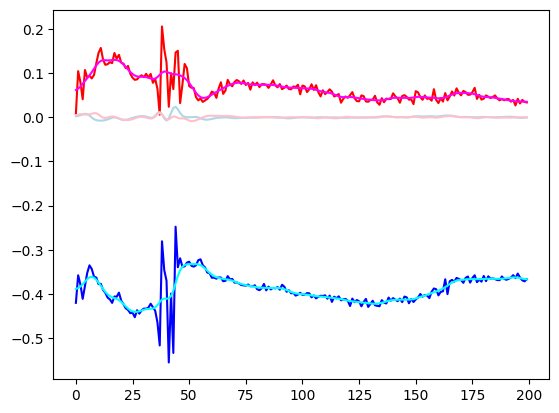

In [539]:
plt.plot(test_frame['L_EYE'],label='Left eye',color='b')
plt.plot(test_frame['R_EYE'],label='Right eye',color='r')

plt.plot(gaussian_filter1d(test_frame['L_EYE'],2.5),label='Left eye',color='cyan')
plt.plot(gaussian_filter1d(test_frame['R_EYE'],2.5),label='Right eye',color='magenta')

plt.plot(np.gradient(gaussian_filter1d(test_frame['L_EYE'],2)),label='Left eye',color='lightblue')
plt.plot(np.gradient(gaussian_filter1d(test_frame['R_EYE'],2)),label='Right eye',color='pink')

In [594]:
# test_frame = final_list_of_fish_dicts[2]['STIM_type_5.SIZE_dot_0.025'][5]
# left_eye_derivative = np.abs(np.gradient(gaussian_filter1d(test_frame['L_EYE'],2)))
# left_eye_derivative_zeroed = []
# for frame in left_eye_derivative:
#     if frame<=0.06:
#         frame=0
#     left_eye_derivative_zeroed.append(frame)
# # plt.plot(test_frame['L_EYE'])
# plt.plot(left_eye_derivative)
# plt.plot(left_eye_derivative_zeroed)

In [590]:
def make_event_table(contrast): 
    fish_distance = contrast['Distance_pts']
    if np.sum(np.isnan(fish_distance)) > 0:
        np.nan_to_num(fish_distance,copy=False,nan=0)
    t = np.arange(0, 200, 1)
    sig = fish_distance #composite signal
    sig_clean = sig #copy for later comparison
    minsignal, maxsignal = sig.min(), sig.max()
    widths = np.arange(1, 200)
    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    t = np.arange(0, 200, 1)
    cwt_sig = cwtmatr[5,:] #composite signal
    signal_clean = sig #copy for later comparison
    minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()
    ## Compute Fourier Transform
    n = len(t)
    fhat = np.fft.fft(cwt_sig, n) #computes the fft
    psd = fhat * np.conj(fhat)/n
    freq = (1/(1*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index
    ## Filter out noise
    threshold = 2
    psd_idxs = psd > threshold #array of 0 and 1
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal
    signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform
    fft_signal = signal_filtered.real
    fft_gauss = gaussian_filter1d(fft_signal,sigma=5)
    fish_distance_2 = []
    for frame in fft_gauss:
        if frame<=1.5:
            frame=0
        fish_distance_2.append(frame)
    fft_gauss = fish_distance_2
    
    # fiter out events mid-beginning and mid-end 
    if fft_gauss[0] != 0:
        zero_start = fft_gauss.index(0)
        fft_gauss[:zero_start] = [0]*(zero_start)
    if fft_gauss[-1] != 0:
        end_zero = -(fft_gauss[::-1].index(0))
        fft_gauss[end_zero:] = [0]*(-end_zero) 
    

    indices = []
    for val in fft_gauss:
        if val == 0:
            indices.append(0)
        else:
            indices.append(fft_gauss.index(val))


    df = pd.DataFrame(fft_gauss,columns=['fft_gauss'])
    df['ind'] = indices
    df['init_cum'] = contrast['CUM_angle']
    df['init_dist'] = contrast['Distance_pts']
    df['event'] = 0


    counter = 1 
    for index, row in df.iterrows():  
        if row['fft_gauss'] != 0:
            df.at[index,'event'] = counter
            if df.at[index+1,'fft_gauss'] == 0:
                counter += 1


    event_df = pd.DataFrame(columns=['event','duration_s','delta_theta_rad','distance','start_ind','end_ind','latency_s'])
    event_df['event'] = df['event'].unique()[1:]

    event_df['duration_s'] = [((df['event']==event).sum())/100 for event in (df['event']).unique()[1:]]

    event_df['start_ind'] = [int(df[df['event']==event].reset_index().iloc[0][0]) for event in (df['event']).unique()[1:]]
    event_df['end_ind'] = [int(df[df['event']==event].reset_index().iloc[-1][0]) for event in (df['event']).unique()[1:]]

    event_df['delta_theta_rad'] = [df['init_cum'][r['end_ind']]-df['init_cum'][r['start_ind']] \
                                   for i, r in event_df.iterrows()]

    event_df['latency_s'] = [None if i-1 == -1 else (event_df['start_ind'][i]-event_df['end_ind'][i-1])/100 \
                             for i, r in event_df.iterrows()]

    # event_df['distance'] = ADD all frames per event except first one
    event_df['distance'] = [df[df['event']==ev]['init_dist'].sum() - df[df['event']==ev]['init_dist'].reset_index()\
                            ['init_dist'][0] for ev in df['event'].unique()[1:]]

    event_df = event_df.drop(columns=['start_ind','end_ind'])
    
    return event_df

In [ ]:
full_event_table = pd.DataFrame(columns=['event_n','fish_n','event','duration_s','delta_theta_rad','distance',\
                                         'latency_s'])

fish_counter = 1
for name,df in zip(df_names,dataframes):
    for fish in df:
        event_df = make_event_table(fish)
#         event_df['time'] = name.split('_')[0]
#         event_df['medium'] = name.split('_')[1]
#         event_df['contrast'] = int(name.split('_')[2])
        event_df['event_n'] = 0
        event_df['fish_n'] = fish_counter
        fish_counter += 1
        full_event_table = pd.concat([full_event_table,event_df])
        
full_event_table['event_n'] = np.arange(1,len(full_event_table)+1,1)
full_event_table = full_event_table.set_index('event_n')

full_event_table

In [591]:
test_frame = final_list_of_fish_dicts[4]['STIM_type_5.SIZE_dot_0.025'][9]

In [592]:
test_events = make_event_table(test_frame)

In [593]:
test_events

,event,duration_s,delta_theta_rad,distance,latency_s
0,1,0.13,0.697165,54.831786,None


/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_46292/493751828.py:15: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.



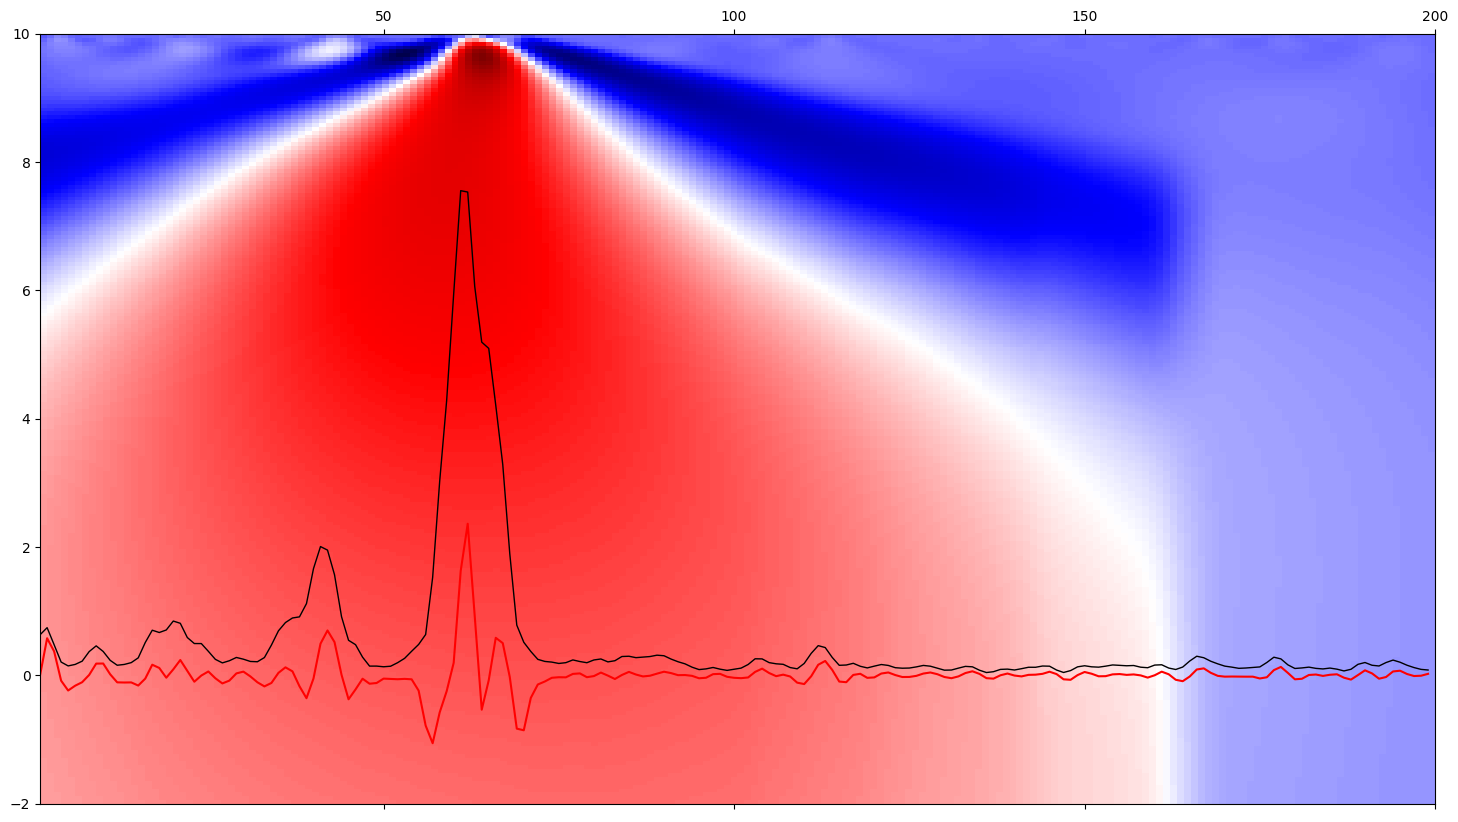

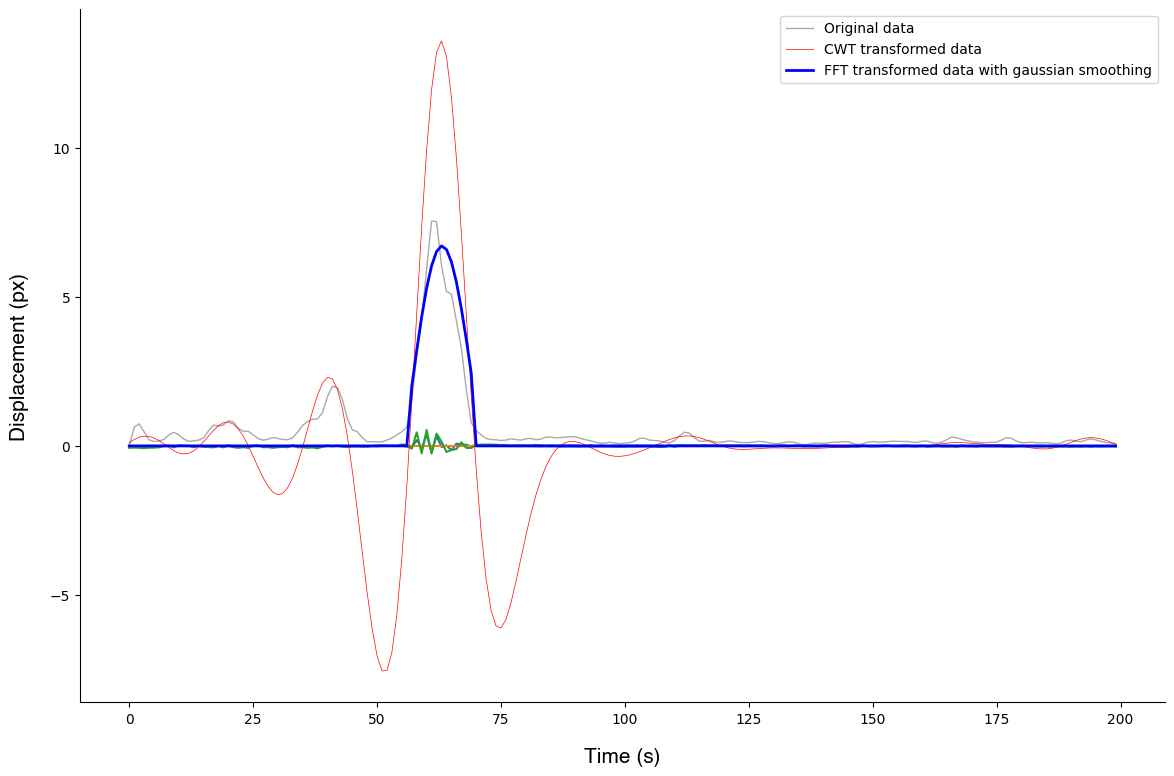

In [586]:
test_frame = final_list_of_fish_dicts[4]['STIM_type_5.SIZE_dot_0.025'][9]
fish_distance = test_frame['Distance_pts']
if np.sum(np.isnan(fish_distance)) > 0:
    np.nan_to_num(fish_distance,copy=False,nan=0)

t = np.arange(0, 200, 1)
sig = fish_distance #composite signal
sig_clean = sig #copy for later comparison
minsignal, maxsignal = sig.min(), sig.max()

widths = np.arange(1, 200)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
fig, ax = plt.subplots(1,1,figsize=(18,10))
ax.plot(cwtmatr[0,:],color='r')
ax.plot(sig,'k',lw=1,color='k')
ax.matshow(cwtmatr.real, extent=[1, 200, -2, 10], cmap='seismic', aspect='auto',interpolation='nearest')
plt.show()

t = np.arange(0, 200, 1)
cwt_sig = cwtmatr[5,:] #composite signal
signal_clean = sig #copy for later comparison
minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()

## Compute Fourier Transform
n = len(t)
fhat = np.fft.fft(cwt_sig, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(1*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

## Filter out noise
threshold = 2
psd_idxs = psd > threshold #array of 0 and 1
psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

fft_signal = signal_filtered.real
fft_gauss = gaussian_filter1d(fft_signal,sigma=5)

fish_distance_2 = []
for frame in fft_gauss:
    if frame<=1.5:
        frame=0
    fish_distance_2.append(frame)
fft_gauss = fish_distance_2

fig, ax = plt.subplots(1,1,figsize=(14,9))
ax.plot(sig,'darkgray',lw=1,label='Original data')
ax.plot(test_frame['MCURVE_tail'])
ax.plot(test_frame['TAIL_P1'])
ax.plot(test_frame['TAIL_P6'])
ax.plot(cwt_sig, 'red', lw=0.5, label='CWT transformed data')
ax.plot(fft_gauss, '-', color='b',lw=2,label='FFT transformed data with gaussian smoothing')
# ax.axhline(y=1, color='r', linestyle='-',lw=0.5,label='threshold line')
ax.legend()
# ax.grid()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# x_ticks = [0, 500, 1000, 1500, 2000, 2500, 3000]
# x_labels = [0,5,10,15,20,25,30] 
# plt.xticks(x_ticks, x_labels,fontsize=13)
# plt.yticks(fontsize=13)
plt.xlabel('Time (s)',size=15,name='Helvetica',labelpad=15)
plt.ylabel('Displacement (px)',size=15,name='Helvetica',labelpad=15)
plt.show()